# Multilabel algorithms over Kunisch P.  
## Seminario de Tesis I, Primavera 2022 
### MDS Program. University of Chile.
#### Supervisor: Prof. Benjamín Bustos, Prof. Iván Sipirán
#### Author: Matías Vergara

### References:

Zhang, M. L., Li, Y. K., Liu, X. Y., & Geng, X. (2018). Binary relevance for multi-label learning: an overview. Frontiers of Computer Science, 12(2), 191–202.
https://doi.org/10.1007/s11704-017-7031-7

Kariuki C. Multi-Label Classification with Scikit-MultiLearn. 
https://www.section.io/engineering-education/multi-label-classification-with-scikit-multilearn/

## Mounting Google Drive



In [1]:
# Mounting google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    folder_path = 'drive/MyDrive/TesisMV/'
except:
    folder_path = '../'

In [2]:
import os
os.listdir(folder_path)

['.git',
 '.gitignore',
 '.idea',
 'actas',
 'features',
 'graficos',
 'labels',
 'models',
 'notebooks',
 'patterns',
 'presentaciones',
 'README.md',
 'requirements.txt',
 'tablas']

## Define flags

In [3]:
#modify only this cell
USE_RN50 = True
SUBCHAPTERS = False
DS_FLAGS = ['blur']
              # 'ref': [invertX, invertY],
              # 'rot': [rotate90, rotate180, rotate270],
              # 'crop': [crop] * CROP_TIMES,
              # 'blur': [blur],
              # 'emboss': [emboss],
              # 'randaug': [randaug],
              # 'rain': [rain],
              # 'elastic': [elastic]
CROP_TIMES = 1
RANDOM_TIMES = 2
ELASTIC_TIMES = 2

In [4]:
# This cells builds the data_flags variable, that will be used
# to map the reques data treatment to folders
MAP_TIMES = {'crop': CROP_TIMES,
         'randaug': RANDOM_TIMES,
         'elastic': ELASTIC_TIMES,
}

DS_FLAGS = sorted(DS_FLAGS)
data_flags = '_'.join(DS_FLAGS) if len(DS_FLAGS) > 0 else 'base'
MULTIPLE_TRANSF = ['crop', 'randaug', 'elastic']
COPY_FLAGS = DS_FLAGS.copy()

for t in MULTIPLE_TRANSF:
    if t in DS_FLAGS:
        COPY_FLAGS.remove(t)
        COPY_FLAGS.append(t + str(MAP_TIMES[t]))
        data_flags = '_'.join(COPY_FLAGS)

subchapter_str = 'subchapters/' if SUBCHAPTERS else ''
patterns_path = folder_path + 'patterns/' + subchapter_str + data_flags + "/"
#labels_path = folder_path + 'labels/' +  subchapter_str + data_flags + "/"
#data_flags = f'resnet50_{data_flags}' if USE_RN50 else f'resnet18_{data_flags}'
#features_path = folder_path + "features/" + subchapter_str + data_flags + '/'

rn = 50
ep = 5
labels_path = folder_path + 'labels/' +  subchapter_str + data_flags + "/"
data_flags = f'resnet50_{data_flags}_e{ep}' if USE_RN50 else f'resnet18_{data_flags}_e{ep}'
features_path = folder_path + f"features/resnet{rn}_blur_each5/resnet{rn}_blur_e{ep}/"

print(features_path)
print(labels_path)
if not (os.path.isdir(features_path) and os.path.isdir(labels_path)):
    raise FileNotFoundError("No existen directorios de datos para el conjunto de flags seleccionado. Verifique que el dataset exista y, de lo contrario, llame a Split and Augmentation {}".format(
        (os.path.isdir(features_path), os.path.isdir(labels_path))))
print("Features set encontrado en {}".format(features_path))
print("Labels set encontrado en {}".format(labels_path))

../features/resnet50_blur_each5/resnet50_blur_e5/
../labels/blur/
Features set encontrado en ../features/resnet50_blur_each5/resnet50_blur_e5/
Labels set encontrado en ../labels/blur/


In [5]:
train_filename = "augmented_train_df.json"
val_filename = "val_df.json"
test_filename = "test_df.json"

# Imports

In [6]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd
import numpy as np
from scipy import sparse

# Base classifiers
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score,hamming_loss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree

# Multilabel classifiers - Problem Transformation
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.ensemble import RakelD

# Multilabel classifiers - Algorithm Adaptation
from skmultilearn.adapt import BRkNNaClassifier
from skmultilearn.adapt import MLkNN
from skmultilearn.adapt import MLTSVM

# Metrics
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Data processing

In [7]:
features_path + test_filename

'../features/resnet50_blur_each5/resnet50_blur_e5/test_df.json'

In [8]:
features_train = pd.read_json(features_path + train_filename, orient='index').sort_index()
features_val = pd.read_json(features_path + val_filename, orient='index').sort_index()
features_test = pd.read_json(features_path + test_filename, orient='index').sort_index()

In [9]:
features_train

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
10d,0.069449,0.359617,0.026743,0.237745,0.275043,0.020247,0.071700,0.061356,0.040967,0.107568,...,0.000638,0.100602,0.096528,0.119866,0.115956,0.019872,0.630965,0.011174,0.286845,0.011350
10d_blur,0.065271,0.352867,0.022676,0.237819,0.283189,0.016334,0.071970,0.059422,0.043443,0.110953,...,0.000420,0.107898,0.101871,0.124382,0.111083,0.019983,0.673862,0.010898,0.279868,0.012854
10e,0.455044,0.382679,0.495363,0.258798,0.253447,0.428301,0.067196,0.120470,0.000958,0.084723,...,0.002278,0.071245,0.075422,0.167131,0.109052,0.017935,0.321284,0.018633,0.277254,0.037310
10e_blur,0.438552,0.402867,0.466784,0.285118,0.272990,0.403858,0.069634,0.109971,0.001743,0.091192,...,0.002206,0.074043,0.080444,0.168911,0.138310,0.018435,0.373052,0.016974,0.310690,0.035395
11c,0.048943,0.333708,0.018475,0.286237,0.316948,0.007525,0.071068,0.039978,0.023625,0.144924,...,0.003013,0.090756,0.137657,0.213251,0.114920,0.018754,1.318247,0.004931,0.374509,0.005922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9b_blur,0.037726,0.206869,0.724596,0.510966,0.625484,0.767165,0.188982,0.942428,0.406419,0.119917,...,0.686195,0.065616,0.081945,0.490774,0.155616,0.102578,0.328167,0.407988,0.590116,0.582946
9c,0.032757,0.144294,1.987628,1.029788,1.290863,2.219210,0.515950,2.468875,1.139350,0.081938,...,1.877757,0.042629,0.060517,0.973303,0.421144,0.319840,0.245509,0.922078,1.233427,1.562918
9c_blur,0.032765,0.137333,1.668757,0.869618,1.109097,1.861230,0.456173,2.119003,0.957277,0.085531,...,1.609398,0.044610,0.066809,0.835635,0.382441,0.283032,0.316885,0.788178,1.054213,1.334852
9e,0.086166,0.213786,0.285148,0.182943,0.298274,0.239788,0.104097,0.411364,0.119632,0.149614,...,0.328130,0.049295,0.058113,0.278394,0.125885,0.051057,0.427334,0.174556,0.325681,0.284182


In [10]:
features_val

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
10b,0.039996,0.197639,0.122938,0.102398,0.099996,0.098653,0.093349,0.383582,0.035066,0.081420,...,0.198168,0.054089,0.059464,0.068581,0.112033,0.041617,0.045723,0.075560,0.234245,0.215388
11a,0.459536,0.207799,0.727955,0.187779,0.184863,0.625791,0.109677,0.383273,0.081325,0.077021,...,0.129684,0.070231,0.085592,0.319699,0.104865,0.036609,0.732181,0.081590,0.211829,0.128603
11b,0.272190,0.260245,0.546654,0.359010,0.350779,0.473007,0.119967,0.509281,0.104401,0.078959,...,0.181866,0.063511,0.100783,0.361334,0.156599,0.032384,0.864198,0.142253,0.381033,0.173477
14d,0.028037,0.118889,0.493045,0.227981,0.297518,0.544140,0.271810,0.704800,0.279847,0.078445,...,0.566464,0.082266,0.088467,0.256346,0.178618,0.150225,0.217076,0.225337,0.279981,0.496213
14g,0.040866,0.347080,0.000000,0.208096,0.114369,0.000026,0.059586,0.048265,0.032891,0.137614,...,0.000000,0.081465,0.123992,0.133983,0.074523,0.017206,0.760978,0.002875,0.201474,0.010404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92c,0.085262,0.371237,0.043517,0.277291,0.333436,0.036540,0.081337,0.000000,0.028472,0.239803,...,0.005963,0.090345,0.082916,0.100770,0.079773,0.023677,0.401480,0.021151,0.220844,0.001975
93a,0.275770,0.177194,0.431269,0.125864,0.214922,0.339856,0.104255,0.238596,0.083399,0.107954,...,0.208701,0.077212,0.087812,0.332246,0.121041,0.047444,0.878923,0.111080,0.130798,0.175661
94c,0.036260,0.197404,0.201762,0.246366,0.217180,0.183310,0.080991,0.399042,0.083722,0.115142,...,0.242967,0.049079,0.062489,0.158849,0.082244,0.027981,0.124770,0.150193,0.353681,0.231059
96c,0.034476,0.160077,0.719470,0.408252,0.490610,0.761867,0.251041,1.051638,0.388687,0.122131,...,0.821603,0.060543,0.058712,0.392275,0.207094,0.148321,0.046339,0.388548,0.482403,0.681762


In [11]:
features_test

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
10a,0.040889,0.201724,0.080330,0.069668,0.156680,0.079481,0.094772,0.164408,0.062217,0.103670,...,0.113196,0.103602,0.101902,0.097953,0.086378,0.041329,0.195488,0.056547,0.075111,0.110058
10c,0.040658,0.312048,0.079591,0.281828,0.354272,0.071290,0.087042,0.277763,0.045544,0.130916,...,0.101267,0.094965,0.096055,0.150783,0.090169,0.034754,0.531189,0.065486,0.313004,0.117867
11f,0.261427,0.266178,0.292118,0.183179,0.127932,0.227765,0.064839,0.145687,0.029883,0.089796,...,0.015466,0.079736,0.140931,0.294417,0.117102,0.016860,1.427206,0.014416,0.226863,0.017112
11h,0.041097,0.374785,0.023283,0.348107,0.497326,0.007453,0.080997,0.039113,0.002503,0.144130,...,0.002042,0.080133,0.157781,0.220938,0.095559,0.018930,1.370562,0.028946,0.373106,0.010852
11k,0.039391,0.484974,0.009688,0.446632,0.246235,0.010531,0.067311,0.022016,0.023567,0.126739,...,0.005554,0.071688,0.127807,0.124846,0.150137,0.017097,0.887786,0.002489,0.581924,0.001525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93g,0.035206,0.230278,0.015685,0.174623,0.265001,0.025654,0.071686,0.037501,0.078142,0.126156,...,0.033701,0.099201,0.218608,0.324543,0.089947,0.018260,2.015962,0.017089,0.163799,0.016642
95c,0.067853,0.212112,0.185102,0.164510,0.241303,0.156354,0.087781,0.239212,0.101755,0.108575,...,0.194141,0.077445,0.076570,0.274769,0.081251,0.029652,0.624272,0.122907,0.198919,0.168837
95k,0.050970,0.209053,0.172279,0.143762,0.295141,0.165530,0.122787,0.268051,0.078327,0.084101,...,0.258894,0.076581,0.123284,0.341558,0.125748,0.068493,1.330816,0.104943,0.164012,0.218823
95l,0.057025,0.344794,0.497191,0.512397,0.542538,0.526106,0.188759,0.675127,0.278392,0.114206,...,0.521378,0.070297,0.099080,0.407593,0.165891,0.085060,0.855930,0.254399,0.589427,0.444901


In [12]:
features_test_val = pd.DataFrame.append(features_test, features_val )

In [13]:
labels_train = pd.read_json(labels_path + train_filename, orient='index').sort_index()
labels_val = pd.read_json(labels_path + val_filename, orient='index').sort_index()
labels_test = pd.read_json(labels_path + test_filename, orient='index').sort_index()

In [14]:
labels_train

,pendent,teardrop,horizontal,panel,group,vertical,bar,floating,enclosing,shorter,...,light,body,bird,striped,worm,angular,raised,head,bird-seed,long
10d,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
10d_blur,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
10e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10e_blur,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9b_blur,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9c_blur,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9e,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
labels_val

,pendent,teardrop,horizontal,panel,group,vertical,bar,floating,enclosing,shorter,...,light,body,bird,striped,worm,angular,raised,head,bird-seed,long
10b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11a,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11b,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14d,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
14g,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93a,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
94c,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96c,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
labels_test

,pendent,teardrop,horizontal,panel,group,vertical,bar,floating,enclosing,shorter,...,light,body,bird,striped,worm,angular,raised,head,bird-seed,long
10a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10c,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11h,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11k,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93g,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95k,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95l,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
labels_test_val = pd.DataFrame.append(labels_test, labels_val)
labels_test_val

,pendent,teardrop,horizontal,panel,group,vertical,bar,floating,enclosing,shorter,...,light,body,bird,striped,worm,angular,raised,head,bird-seed,long
10a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10c,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11h,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11k,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93a,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
94c,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96c,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
def filter_labels(labels_df, freq, number_labels = None):
  """Filters a label dataframe based on labels frequency (number of events)

    Parameters:
    labels_df (DataFrame): dataframe of labels 
    freq (int): threshold frequency. Labels with a lower value will be filtered. 

    Returns:
    DataFrame: filtered labels dataframe

  """
  top_labels = None

  if not number_labels:
    filtered_df = labels_df.loc[:, labels_df.sum(axis=0) > freq]
    top_labels = filtered_df.sum().sort_values(ascending=False)
    return top_labels, 0

  if number_labels:
      filtered_labels = 0
      pivot = freq
      while filtered_labels != number_labels:
              filtered_df = labels_df.loc[:, labels_df.sum(axis=0) > pivot]
              top_labels = filtered_df.sum().sort_values(ascending=False)
              if len(top_labels.values) > number_labels:
                  pivot += 1
              elif len(top_labels.values) < number_labels:
                  pivot -= 1
              else:
                  print("Aplicando threshold {} para trabajar con {} labels".format(pivot, len(top_labels.values)))
                  return top_labels, pivot

def filter_dfs(df, top_labels_df):
  df = df[df.columns.intersection(top_labels_df.index)]
  return df

def combine_dfs(labels_df, top_labels_df, features_df):
  """Combine labels dataframe with features dataframe based on index (patterns names)
     keeping only the most frequent labels.

    Parameters:
    labels_df (DataFrame): dataframe of labels, with patterns name as index
    top_labels_df (DataFrame): a 1D dataframe with the name of the most freq. labels, as 
    the outcome of filter_labels() function 
    features_df (DataFrame): dataframe of features, with patterns name as index 

    Returns:
    DataFrame: combined labels + features dataframe, merged on index

  """
  assert len(labels_df) == len(features_df)
  labels_df = labels_df[labels_df.columns.intersection(top_labels_df.index)]
  final_df = pd.merge(labels_df,       
                      features_df,  
                      left_index=True, right_index=True)
  return final_df

def split_data(final_df, top_labels_df, test_size):
  """Splits the data in train and test. 
    
    Parameters:
    final_df (DataFrame): outcome of combine_dfs.
    top_labels_df (DataFrame): dataframe of most freq. labels. Necessary to 
    know at which column the labels (Y) ends and the features (X) starts  
    freq (int): threshold frequency. Labels with a lower value will be filtered. 
    test_size (float): proportion test/(test+train).

    Returns:
    (np.array, np.array, np.array, np.array): X train, X test, Y train, Y test

  """
  X = np.array(final_df.iloc[:, len(final_df):], dtype=float)
  Y = np.array(final_df.iloc[:, 0:len(final_df)], dtype=float)
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size,random_state=42)
  return X_train, X_test, Y_train, Y_test

In [19]:
top_labels_df, pivot = filter_labels(labels_train, 25, 25) # for example
top_labels_df

Aplicando threshold 50 para trabajar con 25 labels


panel            634
horizontal       508
vertical         242
hatched          240
ornament         228
lozenge          198
metopal          186
filling          168
triangle         138
double           138
cross-hatched    130
meander          114
chain            106
bar               96
outline           76
line              74
single            72
hook              72
dotted            72
zigzag            68
solid             62
turning           60
left              56
dot               54
right             54
dtype: int64

# Data exploration

In [20]:
def get_unique_combinations(labels_df):
  """Returns the number of different combinations of labels in labels_df.

    Parameters:
    labels_df (DataFrame): dataframe of labels 

    Returns:
    int: number of unique labels combinations in labels_df
  """
  unique_combinations = len(labels_df.drop_duplicates())
  print("Number of unique labels combinations: " + str(unique_combinations))
  return unique_combinations

def get_label_metrics(labels_df):
  """Returns label cardinality and label density of a multilabel dataset.
     Label cardinality: average number of labels per entry 
     Label density: fraction of assigned labels over total num of labels,
                    averaged per entry
    Parameters:
    labels_df (DataFrame): dataframe of labels 
    freq (int): threshold frequency. Labels with a lower value will be filtered. 

    Returns:
    DataFrame: filtered labels dataframe

  """
  sum_labels = labels_df.sum(axis=1)
  total_labels = labels_df.shape[0]
  label_cardinality = 0
  for label in sum_labels:
    label_cardinality += label/total_labels
  label_density = label_cardinality/total_labels
  print("Label cardinality: {}".format(label_cardinality))
  print("Label density: {}".format(label_density))
  return(label_cardinality, label_density)

print("Exploring train set")
combinations = get_unique_combinations(labels_train)
metrics = get_label_metrics(labels_train)

Exploring train set
Number of unique labels combinations: 422
Label cardinality: 5.392988929889296
Label density: 0.004975082038643262


# Functions to run experiments and visualizations

In [21]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [22]:
def build_model(mlb_estimator, xtrain, ytrain, xtest, ytest, model=None):
    """Builds a multilabel estimator and runs it over a given train and test data,
       with an optional base classifier model.

    Parameters:
    mlb_estimator (mlb classifier): a PROBLEM_TRANSFORMATION or ALGORITHM_ADAPTATION 
                                    method from sklearn-multilabel
    xtrain, ytrain, xtest, ytest (np arrays): train and test data
    model (Base Estimator): optional, ignored if mlb_estimator is part of 
                            ALGORITHM_ADAPTATION methods. Base classifier to be 
                            used with the PROBLEM_TRANSFORMATION methods.

    Returns:
    (dict, np.array): dict with metrics (exact match, hamming loss and score) 
                      and array of predictions.
    """
    xtrain = sparse.csr_matrix(xtrain)
    ytrain = sparse.csr_matrix(ytrain)
    xtest = sparse.csr_matrix(xtest)
    ytest = sparse.csr_matrix(ytest)
    if model:
      clf = mlb_estimator(model)
    else:
      clf = mlb_estimator
    clf.fit(xtrain, ytrain)
    clf_predictions = clf.predict(xtest)
    clf_predictions = sparse.csr_matrix(clf_predictions)
    exact_match = accuracy_score(ytest,clf_predictions)
    ham_loss = hamming_loss(ytest,clf_predictions)
    ham_score = hamming_score(ytest.toarray(), clf_predictions.toarray())
    result = {"exact_match":exact_match,"hamming_loss": ham_loss, "hamming_score":ham_score}
    return result, clf_predictions

In [23]:
# Plotting linemarks
ALREADY_RUN = False 

# This code has to be executed only once in order to have the same linemarks in 
# each figure
if not ALREADY_RUN:
  import random
  linemark = []
  MARKERS = ['.','+','v','x','*']
  LINE_STYLES = ['-','--','-.',':']

  for i in range(0, 20): 
    linestyle = LINE_STYLES[random.randint(0, len(LINE_STYLES)-1)]
    marker = MARKERS[random.randint(0, len(MARKERS)-1)]
    linemark.append (linestyle + marker)
  
  ALREADY_RUN = True

In [24]:
  def plot_results(x, acc = [], loss = [], score=[], label=[], title = "",
                 xlabel = "", ylabel = "", plot_emr=False, plot_hl=False, plot_hs=True):
    """plots accuracy, hamming loss and hamming score of multiple classifiers.
    
    Returns:
    DataFrame: filtered labels dataframe

    """
    assert len(acc) == len(loss) == len(label)
    if plot_emr:
        f_acc = plt.figure(1)
        f_acc.set_figheight(9)
        f_acc.set_figwidth(7)
        ax1 = f_acc.add_subplot(111)
        ax1.set_title(title + "\n Exact Match Ratio")
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(ylabel)
        ax1.set_ylim(0, 1)
        for i in range(0, len(acc)):
          ax1.plot(x, acc[i],  linemark[i], label=label[i])
        ax1.legend()
        f_acc.show()
    if plot_hl:
        f_loss = plt.figure(2)
        f_loss.set_figheight(9)
        f_loss.set_figwidth(7)
        ax2 = f_loss.add_subplot(111)
        ax2.set_title(title  + "\n Hamming Loss")
        ax2.set_xlabel(xlabel)
        ax2.set_ylabel(ylabel)
        for i in range(0, len(loss)):
          ax2.plot(x, loss[i], linemark[i], label=label[i])
        ax2.legend()
        f_loss.show()

    if plot_hs:
        f_score = plt.figure(3)
        f_score.set_figheight(9)
        f_score.set_figwidth(7)
        ax3 = f_score.add_subplot(111)
        ax3.set_title(title  + "\n Hamming Score")
        ax3.set_xlabel(xlabel)
        ax3.set_ylabel(ylabel)
        ax3.set_ylim(0, 1)
        for i in range(0, len(score)):
          ax3.plot(x, score[i], linemark[i], label=label[i])
        ax3.legend()
        f_score.show()

In [25]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
    """
    Prints confusion matrix for multilabel classification.
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(class_label)

def plot_multiple_matrix(cfs_matrix, present_labels, nrows=5, ncols=5, figsize=(12,20), filename="results"):
  """
  Plots multiple confusion matrix

  Parameters:
  cfs_matrix (2D array): an array containing the multiple confusion matrix as
                         outcome of multilabel_confusion_matrix()
  present_labels (1D array): array of strings with name of labels, in the same
                             order as they are in cfs_matrix
  nrows, ncols, figsize: number of rows, columns and size of the plot
  
  """
  fig, ax = plt.subplots(nrows, ncols, figsize=figsize)

  for axes, cfs_vals, label in zip(ax.flatten(), cfs_matrix, present_labels):
      print_confusion_matrix(cfs_vals, axes, label, ["N", "Y"])

  fig.tight_layout()
  plt.show()
  plt.savefig(filename + ".png")

# Benchmark


In [26]:
data_flags

'resnet50_blur_e5'

In [27]:
#MIN_FREQS = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24,
#            26, 30, 34, 38, 40, 50, 60, 80, 100]
#MIN_FREQS = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
labels_25, pivot = filter_labels(labels_train, 25, 25)
freq_25 = labels_25.shape[0]
MIN_FREQS = [int(pivot * 0.7), pivot, int(pivot * 1.3)]
MIN_FREQS = [pivot]

TRANSF_METHODS = {"BR": BinaryRelevance, "LP": LabelPowerset,
                  "CC": ClassifierChain, "RakelD": RakelD}
mlknn = MLkNN(k=1, s=1)
mltsvm = MLTSVM(c_k=4)
brknna = BRkNNaClassifier(k=1)
ADAPT_METHODS = {"MLkNN": mlknn} #, "MLTSVM": mltsvm, "BRkNN": brknna}
BASE_CLASSIFIERS = {"LR": LogisticRegression(solver='lbfgs'),
                    "SVC": svm.SVC()}#, "DT": tree.DecisionTreeClassifier()} # "GNB": GaussianNB()
exp_exact_match = {}
exp_hscore = {}
exp_hloss = {}

for meth_name in TRANSF_METHODS.keys():
  for base_name in BASE_CLASSIFIERS.keys():
    exp_exact_match[meth_name + "_" + base_name] = []
    exp_hscore[meth_name + "_" + base_name] = []
    exp_hloss [meth_name + "_" + base_name] = []

for meth_name in ADAPT_METHODS.keys():
  exp_exact_match[meth_name] = []
  exp_hscore[meth_name] = []
  exp_hloss [meth_name] = []

for i in MIN_FREQS:
  print("Starting with i={}".format(i))
  # Dataset creation
  top_labels_i, _ = filter_labels(labels_train, i)
  X_train = features_train
  X_test = features_test_val   # labels_test_val since val examples are unrecognized to multilabel algorithms
  Y_train = filter_dfs(labels_train, top_labels_i) # reduce labels to most freq
  Y_test = filter_dfs(labels_test_val, top_labels_i) # in both train and test

  for meth_name, method in ADAPT_METHODS.items():
    output_i, predictions_i = build_model(method, X_train, Y_train, X_test, Y_test)
    exp_exact_match[meth_name].append(output_i['exact_match'])
    exp_hscore[meth_name].append(output_i['hamming_score'])
    exp_hloss[meth_name].append(output_i['hamming_loss'])

  # Linear regression and SVC will raise error if Y_train is composed by only one class
  for meth_name, method in TRANSF_METHODS.items():
    for base_name, classifier in BASE_CLASSIFIERS.items():
      output_i, _ = build_model(method, X_train, Y_train, X_test, Y_test, model=classifier)
      exp_exact_match[meth_name + "_" + base_name].append(output_i['exact_match'])
      exp_hscore[meth_name + "_" + base_name].append(output_i['hamming_score'])
      exp_hloss[meth_name + "_" + base_name].append(output_i['hamming_loss'])


Aplicando threshold 50 para trabajar con 25 labels
Starting with i=50


D:\Programas\Anaconda3\envs\TesisMV38\lib\site-packages\skmultilearn\cluster\random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
D:\Programas\Anaconda3\envs\TesisMV38\lib\site-packages\skmultilearn\cluster\random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)


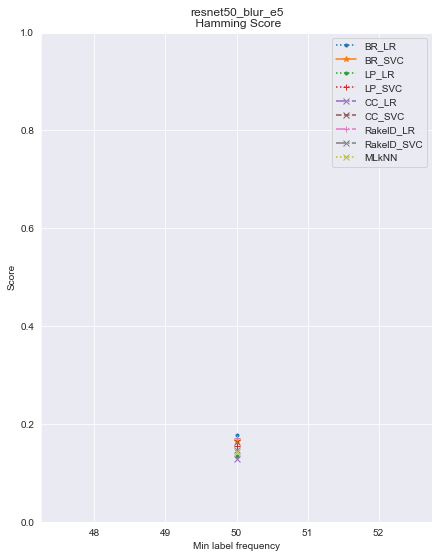

In [28]:
plot_results(MIN_FREQS,
             acc = list(exp_exact_match.values()),
             loss = list(exp_hloss.values()),
             score = list(exp_hscore.values()),
             label= list(exp_exact_match.keys()),
             title = data_flags,
            xlabel = "Min label frequency", ylabel = "Score")

# Best model at a given threshold

In [29]:
for m, hl in zip(exp_exact_match.keys(), exp_hscore.values()):
    print(m, hl)

BR_LR [0.17813390313390312]
BR_SVC [0.16431623931623932]
LP_LR [0.13465269298602633]
LP_SVC [0.15595238095238095]
CC_LR [0.1275997150997151]
CC_SVC [0.16324786324786325]
RakelD_LR [0.17089268755935422]
RakelD_SVC [0.146011396011396]
MLkNN [0.14172432505765836]


In [30]:
THRESHOLD = pivot
print(THRESHOLD)
METHOD = "LP" # | "MLTSVM" | "BRkNN" | "CC" | "RakelD" | "LP" | "MLkNN" | "BR"
BASE_CLF = "SVC" # | "SVC" | "DT" | "GNB" | "LR"

top_labels, _= filter_labels(labels_train, THRESHOLD)
print("ATTENTION: TESTING WITH {} LABELS".format(len(top_labels)))
X_train = features_train
Y_train = filter_dfs(labels_train, top_labels)
X_test = features_test_val
Y_test = filter_dfs(labels_test_val, top_labels)


clf = BASE_CLASSIFIERS[BASE_CLF]
if METHOD in ADAPT_METHODS.keys():
  met = ADAPT_METHODS[METHOD]
  clf_model, predictions = build_model(met, X_train, Y_train, X_test, Y_test)
else:
  met = TRANSF_METHODS[METHOD]
  clf_model, predictions = build_model(met, X_train, Y_train, X_test, Y_test, clf)

print("HAMMING SCORE: {}".format(clf_model['hamming_score']))
predictions = predictions.toarray()
present_labels = top_labels.index

cfs_matrix = multilabel_confusion_matrix(Y_test, predictions)
class_report = classification_report(Y_test,
                                      predictions,
                                      output_dict=False,
                                      target_names=present_labels)
print(class_report)

50
ATTENTION: TESTING WITH 25 LABELS
HAMMING SCORE: 0.15595238095238095
               precision    recall  f1-score   support

        panel       0.30      0.47      0.37        77
   horizontal       0.34      0.44      0.38        91
     vertical       0.00      0.00      0.00        19
      hatched       0.00      0.00      0.00         4
     ornament       0.00      0.00      0.00        12
      lozenge       0.00      0.00      0.00        26
      metopal       0.00      0.00      0.00        59
      filling       0.08      0.39      0.14        23
     triangle       0.00      0.00      0.00         0
       double       0.00      0.00      0.00         0
cross-hatched       0.14      0.47      0.22        34
      meander       0.00      0.00      0.00         6
        chain       0.00      0.00      0.00        21
          bar       0.00      0.00      0.00        13
      outline       0.00      0.00      0.00         0
         line       0.00      0.00      0.00   

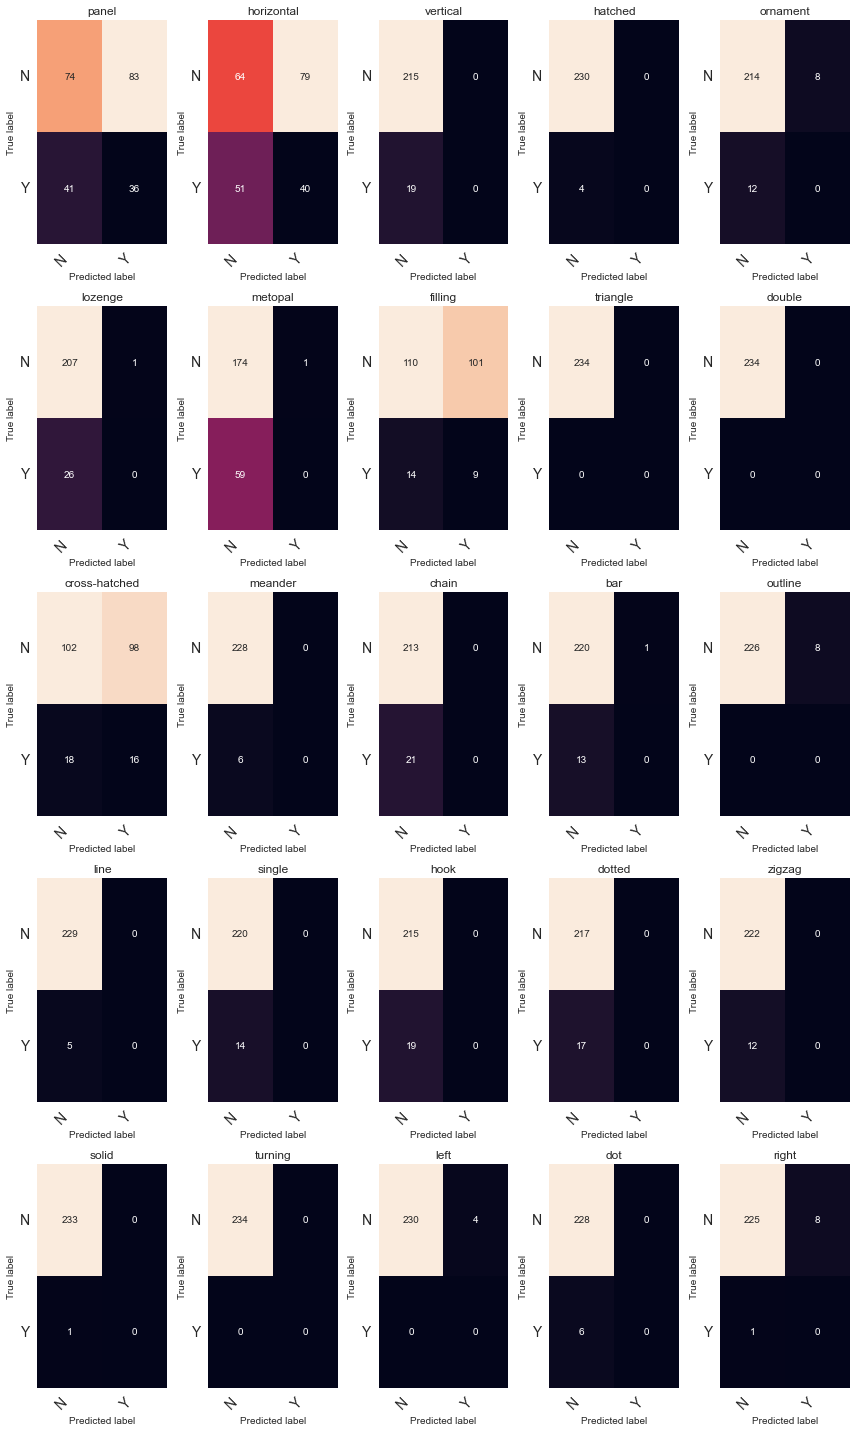

<Figure size 432x288 with 0 Axes>

In [31]:
plot_multiple_matrix(cfs_matrix, present_labels)

# Binary Relevance with handcrafted class balance

In [32]:
def split_balanced(label, columns, X_train, Y_train):
  """Generates a balanced train and test dataset for a given label
    ATTENTION: MODIFIED TO ADD ONLY ORIGINAL PATTERNS TO THE NEGATIVE DATASET

    Parameters:
    label (String): label with which the balanced dataset will be created
    colnames (1D array):
    X_train, Y_train (dataFrames): original (potentially unbalanced) train datasets.

    Returns:
    X_train, Y_train (dataFrames): train datasets with equal number of positive and
                                  negative events for the given label. 

  """
  index_label = columns.tolist().index(label)
  indexes_positives = []
  indexes_negatives = []

  i=0
  for index, row in Y_train.iterrows():
    if row.values[index_label] == 1:
      indexes_positives.append(i)
    elif "_" not in index:
      indexes_negatives.append(i)
    i+=1
  indexes_negatives = indexes_negatives[0:len(indexes_positives)]
  final_indexes = indexes_positives + indexes_negatives
  final_indexes.sort()
  X_train = X_train.values[final_indexes, :]
  Y_train = Y_train.values[final_indexes, index_label]
  return X_train, Y_train

In [33]:
if False:
    base_classifiers = {}
    THRESHOLD = 180

    top_labels, _ = filter_labels(labels_train, THRESHOLD)
    print("ATTENTION: TESTING WITH {} LABELS".format(len(top_labels)))
    X_train = features_train
    Y_train = filter_dfs(labels_train, top_labels)
    X_test = features_test
    Y_test = filter_dfs(labels_test, top_labels)
    columns = Y_test.columns
    predictions = []

    for i in range(0, len(top_labels)):
      label = columns[i]
      bc = LogisticRegression(solver='lbfgs')
      X_train_label, Y_train_label = split_balanced(label, columns, X_train, Y_train) # tantos positivos como posible e igual a negativos
      bc.fit(X_train_label, Y_train_label)
      base_classifiers[label] = bc
      clf_prediction = bc.predict(X_test.values)
      predictions.append(clf_prediction) # una columna de prediccion

    predictions = np.array(predictions).T

    exact_match = accuracy_score(Y_test.values, predictions)
    ham_loss = hamming_loss(Y_test.values, predictions)
    ham_score = hamming_score(Y_test.values, predictions)

    #print("Exact match ratio: {}".format(exact_match))
    #print("Hamming loss: {}".format(ham_loss))
    print("Hamming score: {}".format(ham_score))

In [34]:
if False:
    present_labels = top_labels.index
    cfs_matrix = multilabel_confusion_matrix(Y_test, predictions)
    class_report = classification_report(Y_test,
                                          predictions,
                                          output_dict=False,
                                          target_names=present_labels)
    print(class_report)

In [35]:
#plot_multiple_matrix(cfs_matrix, present_labels)